# Neural Networks

## My first neural network: StupidNet™

In [5]:
import torch
from torch import nn
import os

def set_manual_seed(seed=114514):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

### Loading and transforming the dataset

#### Question 1 & 2

<class 'torch.Tensor'>
torch.Size([784]) 0


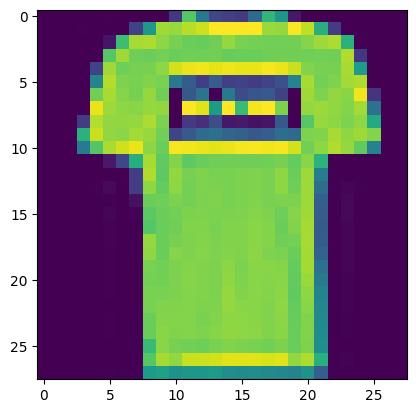

In [2]:
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x))  # 将张量展平为一维
])

training_data = datasets.FashionMNIST("../", train=True, transform=transform)
test_data = datasets.FashionMNIST("../", download=True, train=False, transform=transform)

print(type(training_data[1][0]))
print(training_data[1][0].shape, training_data[1][1])
plt.imshow(training_data[1][0].reshape(28,28))

#### Question 3, 4 & 5

In [ ]:
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm

def trainer(dataset, model, loss_fn, epoch=10, batch_size=64, rate=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    # Useless for a single-layer network but we will keep it in order not to lose the generality
    model.train()
    
    dataloader = DataLoader(dataset, batch_size, shuffle=True)
    
    optimizer = Adam(model.parameters(), lr=rate)
    
    for epoch_idx in range(epoch):
        
        pbar = tqdm(dataloader, desc=f"Epoch {epoch_idx+1}/{epoch}", ncols=100)
        
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            pbar.set_postfix(loss=loss.item())

In [ ]:
model_TD1 = nn.Linear(in_features=training_data[0][0].shape[0], out_features=1)

#### Question 6

In [ ]:
def MSE():
    # patch outputs shape and target dtype
    loss_fn = nn.MSELoss()
    return lambda outputs, labels: loss_fn(outputs.squeeze(1), labels.float())

set_manual_seed()    
nn.init.normal_(model_TD1.weight, mean=0.0, std=0.2)
nn.init.zeros_(model_TD1.bias)

trainer(training_data, model_TD1, MSE(), batch_size=50, epoch=30)

os.makedirs('work_dir', exist_ok=True)
torch.save(model_TD1.state_dict(), './work_dir/model_TD1.pt')

In [ ]:
def success_rate(model_TD1, test_data):
    correct = 0
    total = 0
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
    model_TD1.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(model_TD1.weight.device), labels.to(model_TD1.weight.device).to(torch.int32)
            outputs = model_TD1(images)
            pred = torch.round(outputs, decimals=0).squeeze(1).to(torch.int32)
            total += labels.shape[0]
            correct += (pred == labels).sum().item()
    print(f"{correct} out of {total} correct")
    return correct/total

print(f"Success Rate of model_TD1: {success_rate(model_TD1, test_data)}")

### Improving StupidNet™: our second neural network

#### Question 7

In [ ]:
model_10 = nn.Sequential(
    nn.Linear(in_features=training_data[0][0].shape[0], out_features=10),
    nn.LogSoftmax(dim=1)
)

# dummy_input = torch.randn(size=(13,784))
# probs_ = torch.exp(model_10(dummy_input))
# assert torch.allclose(
#         torch.sum(probs_, axis=1),
#         torch.ones(13))

In [8]:
set_manual_seed()
nn.init.normal_(model_10[0].weight, mean=0.0, std=0.2)
nn.init.zeros_(model_10[0].bias)

trainer(training_data, model_10, nn.NLLLoss(), batch_size=50, epoch=30)

os.makedirs('work_dir', exist_ok=True)
torch.save(model_10.state_dict(), './work_dir/model_10.pt')

Epoch 30/30: 100%|█████████████████████████████████| 1200/1200 [00:11<00:00, 108.73it/s, loss=0.409]


In [17]:
def success_rate_vector(model_10, test_data):
    correct = 0
    total = 0
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
    model_10.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(model_10[0].weight.device), labels.to(model_10[0].weight.device).to(torch.int32)
            outputs = model_10(images)
            pred = torch.argmax(outputs, dim=1)
            total += labels.shape[0]
            correct += (pred == labels).sum().item()
    print(f"{correct} out of {total} correct")
    return correct/total

print(f"Success Rate of model_TD1: {success_rate_vector(model_10, test_data)}")

8333 out of 10000 correct
Success Rate of model_TD1: 0.8333


### Activation Functions

In [ ]:
model_ReLU = nn.Sequential(
    nn.Linear(in_features=training_data[0][0].shape[0], out_features=10),
    nn.ReLU(),
    nn.LogSoftmax(dim=1) # Since we use nn.NLLLoss, using logsoftmax to normalize is recommended
)

model_sigmoid = nn.Sequential(
    nn.Linear(in_features=training_data[0][0].shape[0], out_features=10),
    nn.Sigmoid(),
    nn.LogSoftmax(dim=1)
)


model_tanh = nn.Sequential(
    nn.Linear(in_features=training_data[0][0].shape[0], out_features=10),
    nn.Tanh(),
    nn.LogSoftmax(dim=1)
)

In [24]:
def train_and_test(model, model_name, test_data, save=True):
    set_manual_seed()
    nn.init.normal_(model_10[0].weight, mean=0.0, std=0.2)
    nn.init.zeros_(model_10[0].bias)

    trainer(training_data, model, nn.NLLLoss(), batch_size=64, epoch=30)
    
    print(f"Success Rate of model_TD1: {success_rate_vector(model, test_data)}")
    
    if save:
        save_dir = f"./work_dir/{model_name}.pt"
        print(f"saving to {dir}")
        os.makedirs('work_dir', exist_ok=True)
        torch.save(model_10.state_dict(), save_dir)

In [ ]:
train_and_test(model_ReLU, "model_RELU", test_data)
train_and_test(model_sigmoid, "model_sigmoid", test_data)
train_and_test(model_tanh, "model_tanh", test_data)

Epoch 8/30:  56%|████████████████████▋                | 526/938 [00:03<00:03, 132.41it/s, loss=1.19]

## Training using GPU

We already implemented the GPU version to train our neural network.

## Using Classes

In [ ]:
import torch
from torch import nn

class SingleLayerNN(nn.Module): # a class inheriting from nn.Module
	def __init__(self): 
		super().__init__()
		self.net  = nn.Sequential(
    		nn.Linear(in_features=training_data[0][0].shape[0], out_features=10),
    		nn.ReLU()
		)
	def forward(self, x): 
		return self.net(x)